In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_gender = pd.read_csv('data/gender_submission.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning
There's likely some missing data in here which we can actually see a few examples of in the `head` output above. Let's check out the rest of the dataset and identify where we may have other `NaN` values. From there, we'll have to think about either imputting or dropping the values.

In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [6]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Looks like there's quite a few with missing ages which we can fairly easily impute with a median age. Cabin has a lot of NAs as well and perhaps not so easily imputted. We'll set that aside for now. Embarked (where passenger got on ship) also has a few missing values, but it's unclear if this feature would be important in survival rates to begin with. For now, it looks like we can focus on imputing values for age.

In [7]:
# impute median age for missing values
median_age_train = df_train["Age"].median()
df_train["Age"].fillna(median_age_train, inplace=True)

median_age_test = df_test["Age"].median()
df_test["Age"].fillna(median_age_test, inplace=True)

In [8]:
df_train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

Let's leave the remaining `NA`s alone for now. If we discover these might be important, we can come back and make some changes.

## Exploratory Data Analysis
Let's see if we can find any meaningful patterns in the data. We'll pick out some attributes that seem like they could be candidates to separate the data and see what we find. Sex, pclass, age, sibsp, parch, fare, and cabin seem like they could be important factors here, so we'll start looking at those. 

### Sex (`Sex`)

In [9]:
# difference in survival by sex
df_survival_mf = df_train[['Sex', 'Survived']].groupby(['Sex']).mean()
df_survival_mf

,Survived
Sex,
female,0.742038
male,0.188908


Wow. Well, right off the bat, we see that sex seems to show a huge difference in survival rates. This will be a key feature for whatever model we choose. Let's take a look at `Pclass` and see if perhaps adding that makes much of a difference.

### Age (`Age`)
It will be interesting to see how age figures into survival rates. I would expect the young children and those in advanced age to have poor survival rates given they would have a much more difficulty with prolonged exposure to the frigid waters where the Titanic sank. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f51eba8>]],
      dtype=object)

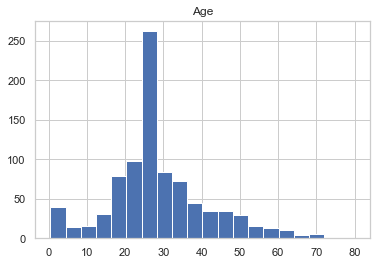

In [18]:
df_train.hist(column='Age', bins=20)

The distribution is basically right-skewed unimodal and about what you'd expect with the majority of passengers between 20-40 years old.

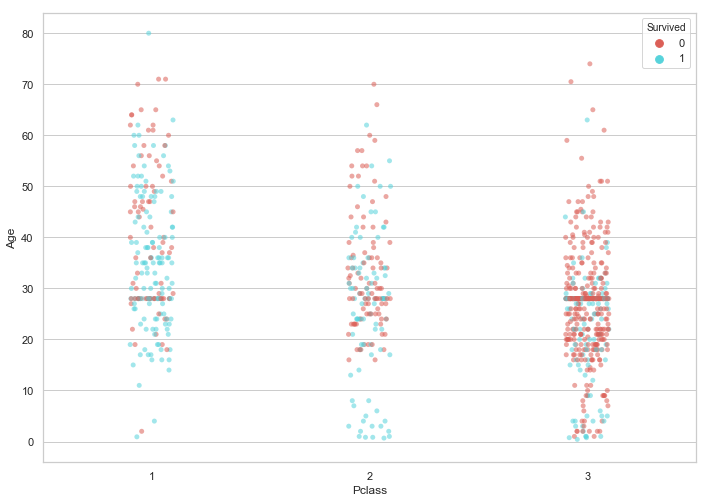

In [48]:
ax = sns.stripplot(x='Pclass', y='Age', hue='Survived', palette='hls',
                   data=df_train, jitter=True, alpha=.55)

There aren't that many children in the upper class, and they tend to skew older. In upper and middle class, children in general fare pretty well. In the lower class, the situation is not as rosy---a theme we'll see come up repeatedly.

### Passenger Class (`Pclass`) and Fare (`fare`)
The Titanic movie taught me that the poor were treated quite poorly and . Fare likely has a similar response to survival and may indeed serve as a proxy to `pclass`.

We'll also separate by sex to see if the previous trend we saw continues to hold true.


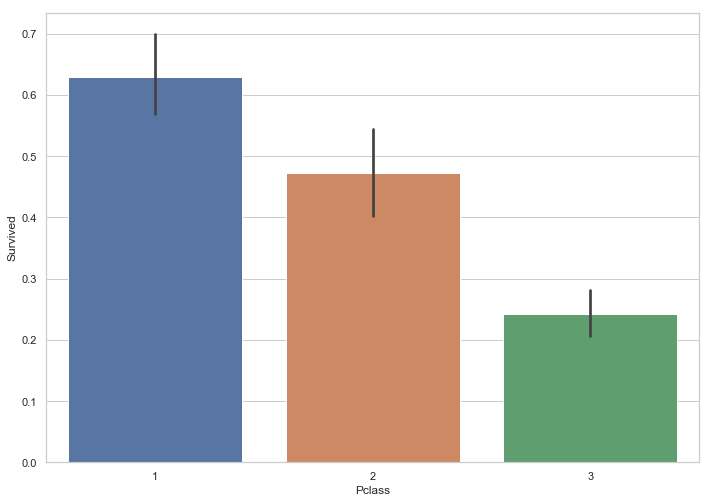

In [49]:
df_survival_class = df_train[['Pclass', 'Survived']].groupby(level=0).mean()
sns.set(style="whitegrid")
ax = sns.barplot(x='Pclass', y='Survived', data=df_survival_class)

In [50]:
df_survival_class_sex = df_train[['Pclass', 'Sex', 'Survived']].groupby(['Pclass', 'Sex']).mean()
df_survival_class_sex.reset_index(inplace=True)
df_survival_class_sex

,Pclass,Sex,Survived
0,1,female,0.968085
1,1,male,0.368852
2,2,female,0.921053
3,2,male,0.157407
4,3,female,0.500000
5,3,male,0.135447


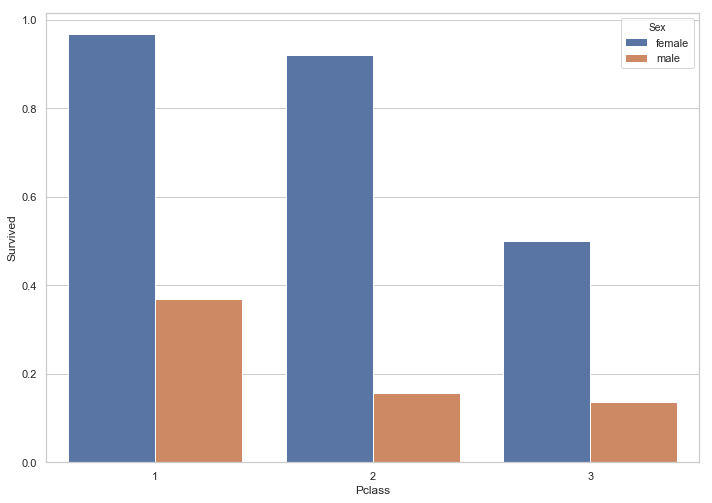

In [51]:
ax = sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df_survival_class_sex)

So it looks like women in the upper classes (1 and 2) fared much better overall than any other group. In fact, if you're a female in classes 1 or 2, you stand a $>90\%$ chance of surviving. Women in general did better overall, but in lower classes for men, things look pretty grim. I guess social science via blockbuster Hollywood movie may have some validity after all!

In [52]:
corr_matrix = df_train.corr()

In [53]:
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.034212,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500
Age,0.034212,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688
SibSp,-0.057527,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000


### Family Relations (`sibsp` and `parch`)

